#### Fork process creation method

Include the analysis script and setup the folders with raw data

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments")
s3_folder_filter="1711-fork/s3/*benchmark_e2e*"
scratch_folder_filter="1711-fork/scratch/*benchmark_e2e*"

#### Load raw data

In [3]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 276.31it/s]


In [4]:
# Show data (to check if loaded correctly)

# df_dataloader_s3.sort_values(["start_time_x"], ascending=False)
# df_dataloader_scratch.sort_values(["start_time_x"], ascending=False)

In [5]:
# extract unique functions (for s3 and scratch, it's the same)
unique_functions_s3 = np.unique(df_dataloader_s3["item_x"])

# define colors for timelane items 
colors = {}
for i, color in zip(unique_functions_s3, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
    
# define lanes (each lane is for a single function call (i.e. usage))
lanes={}
for i, lane in zip(unique_functions_s3, range(len(unique_functions_s3))):
    lanes[str(i)] = lane

# print to verify
print(f"Unique functions: {unique_functions_s3}")
print(f"Lanes: {lanes}")
    
# get the names of the runs for the iterators later on 
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']
Lanes: {'batch': 0, 'next_data': 1, 'run_training_batch': 2, 'training_batch_to_device': 3}


#### Timeline plots

Each line corresponds to a unique function call.

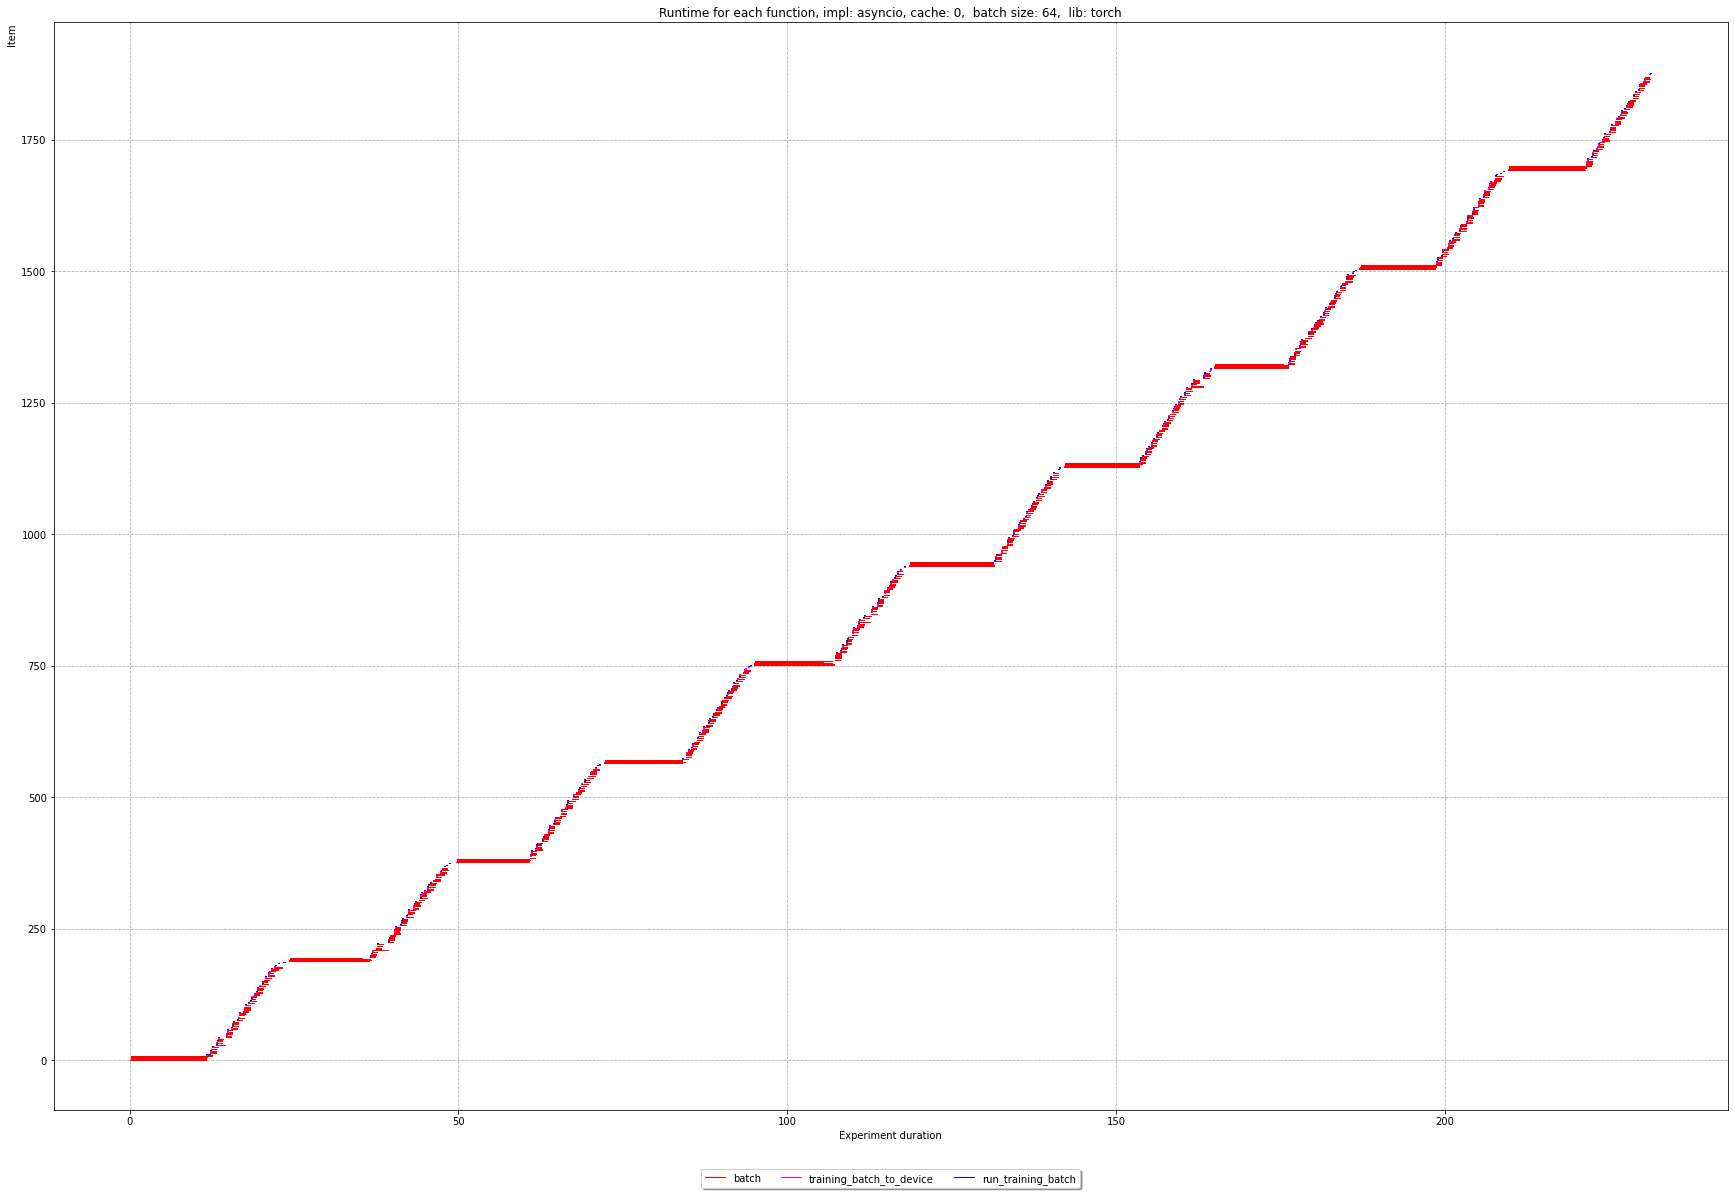

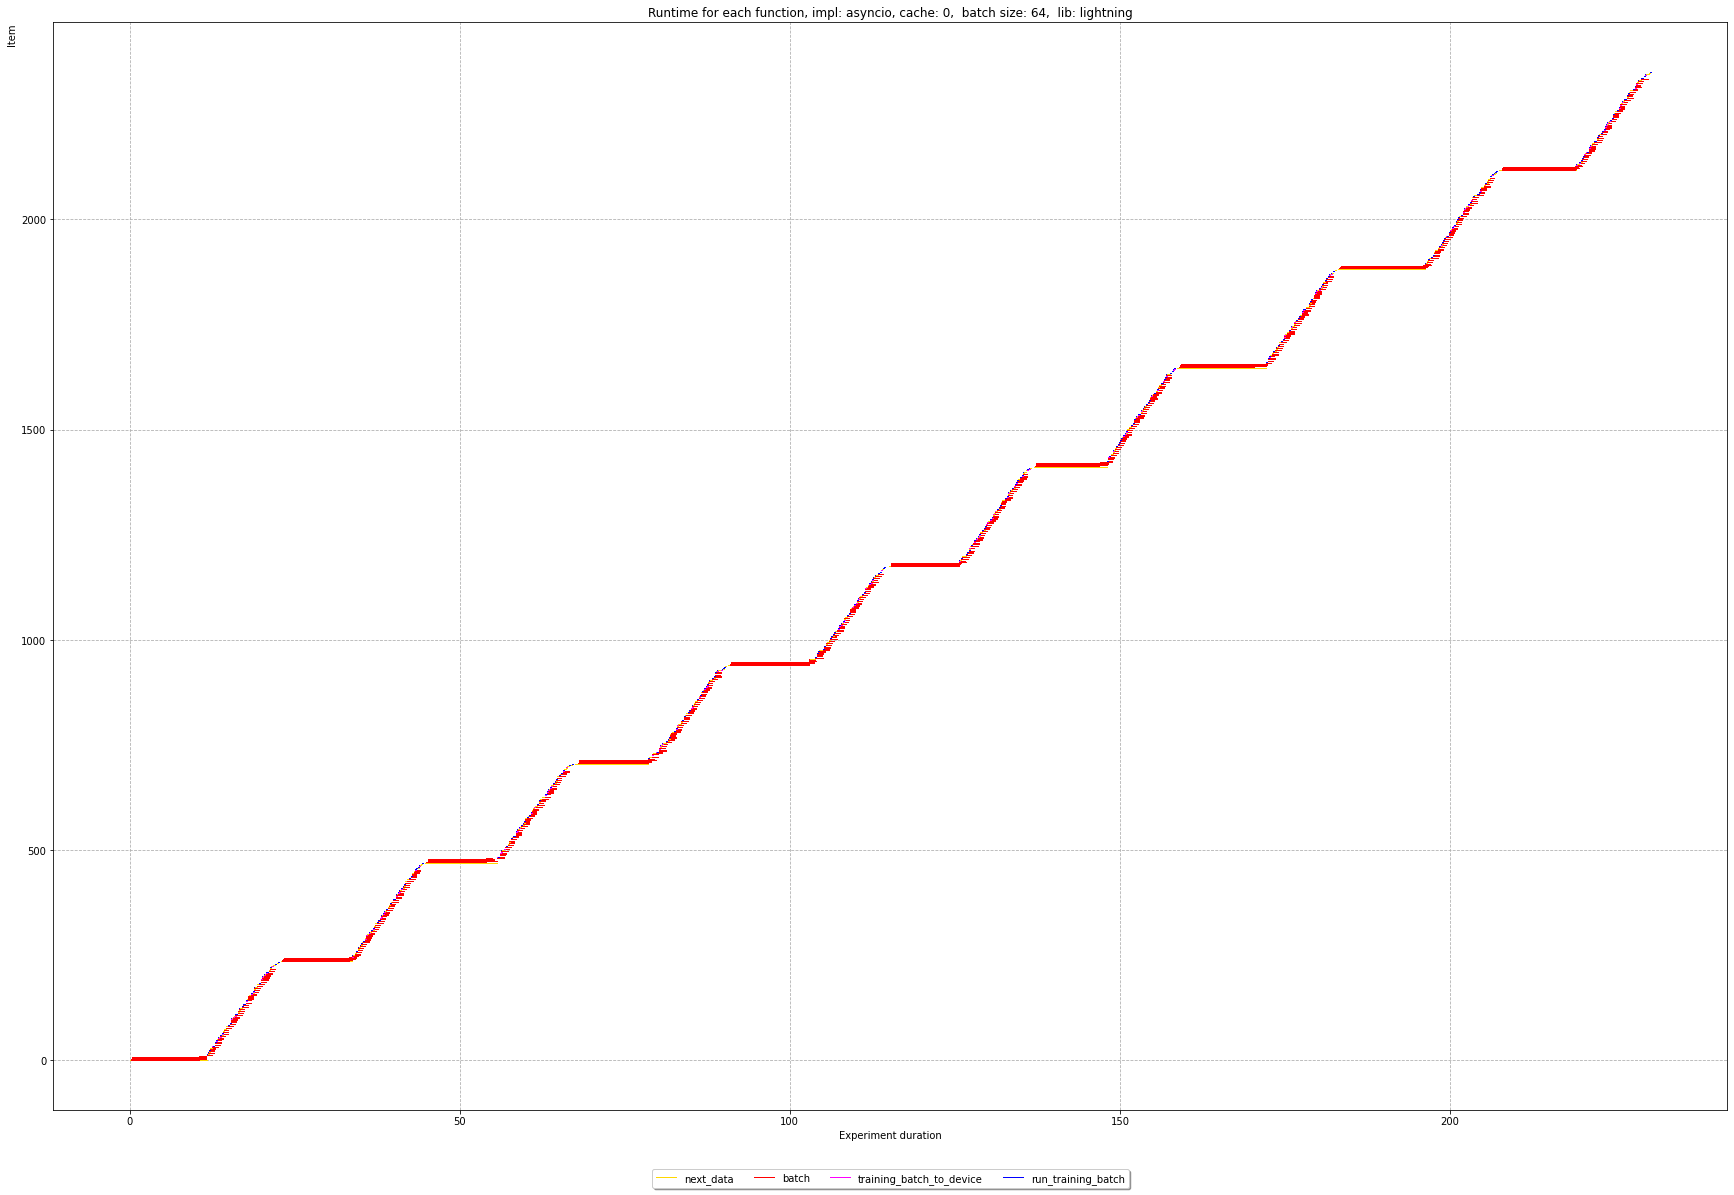

In [6]:
for implementation in ["torch", "lightning"]:
    for run in unique_runs_s3:
        if implementation in run:
            df = df_dataloader_s3[(df_dataloader_s3["run"]==run)]
            show_timelines(df, run, lanes, colors, False, False, 1)

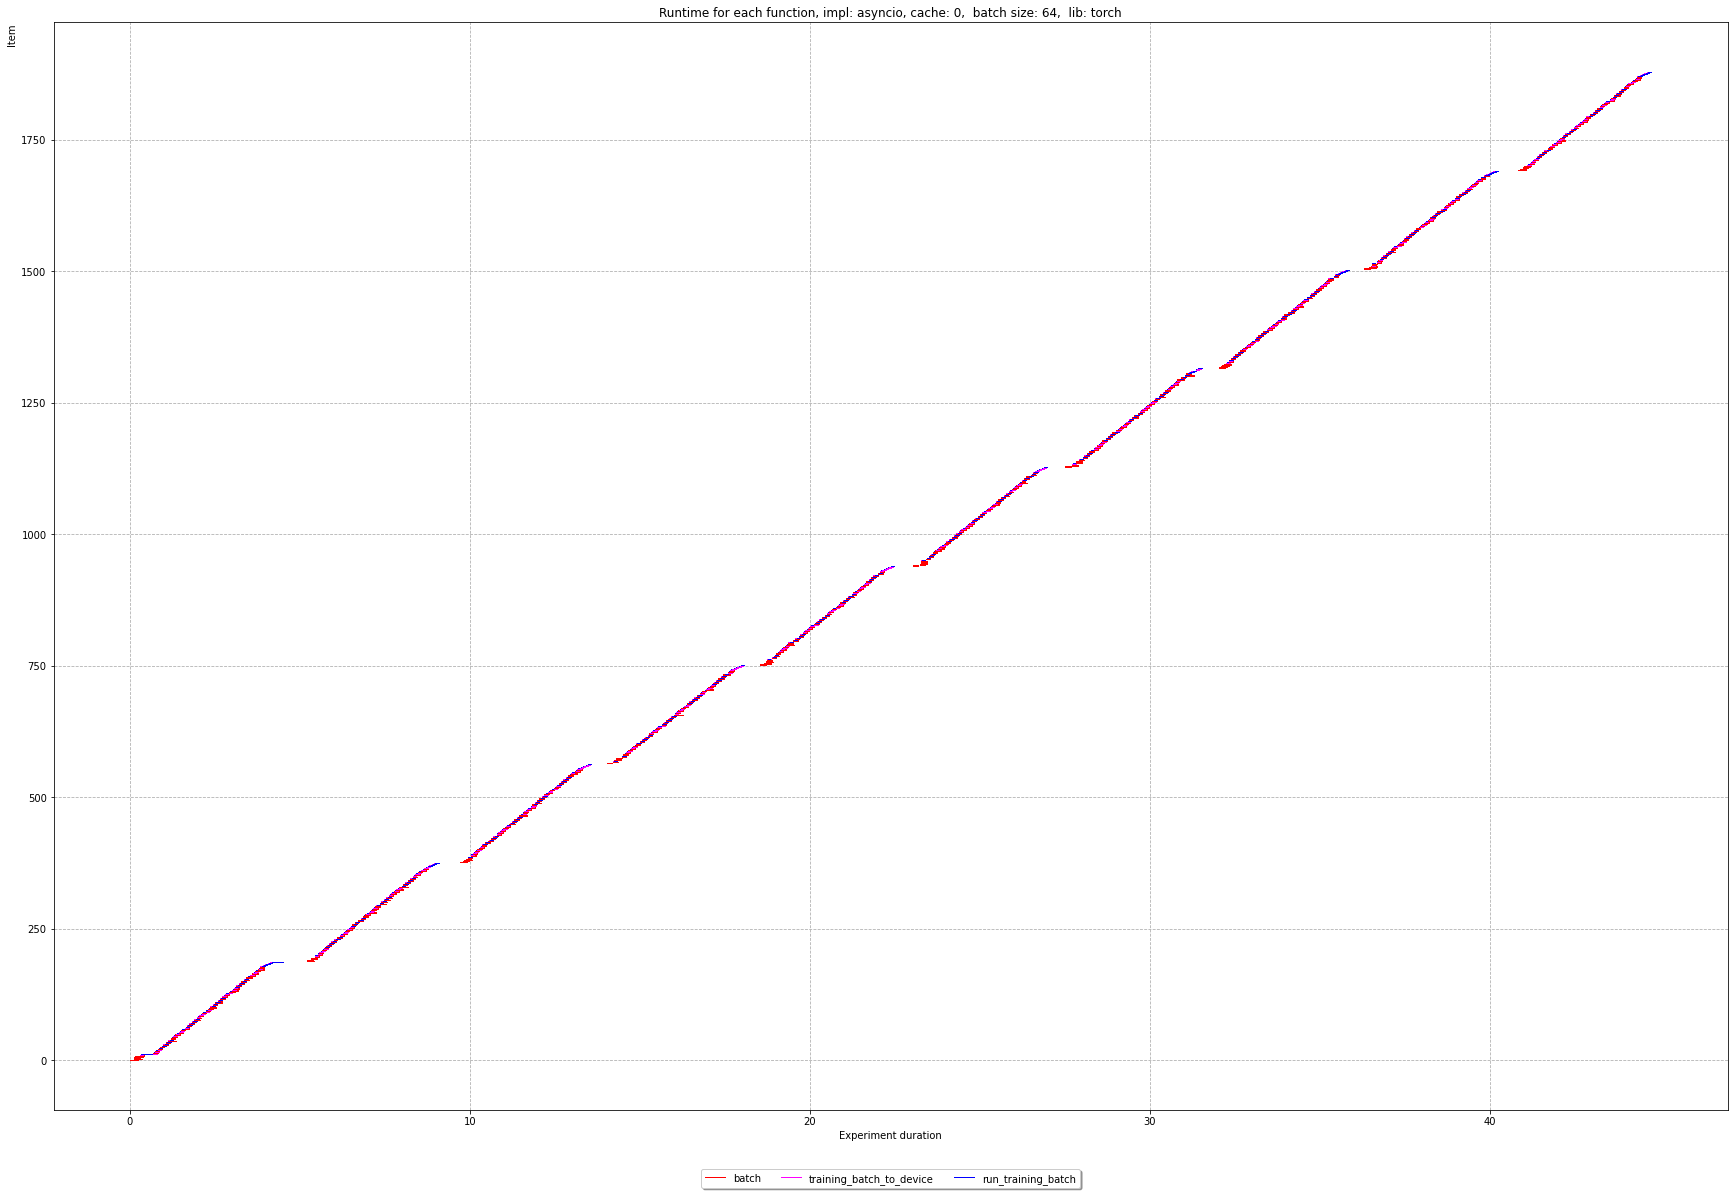

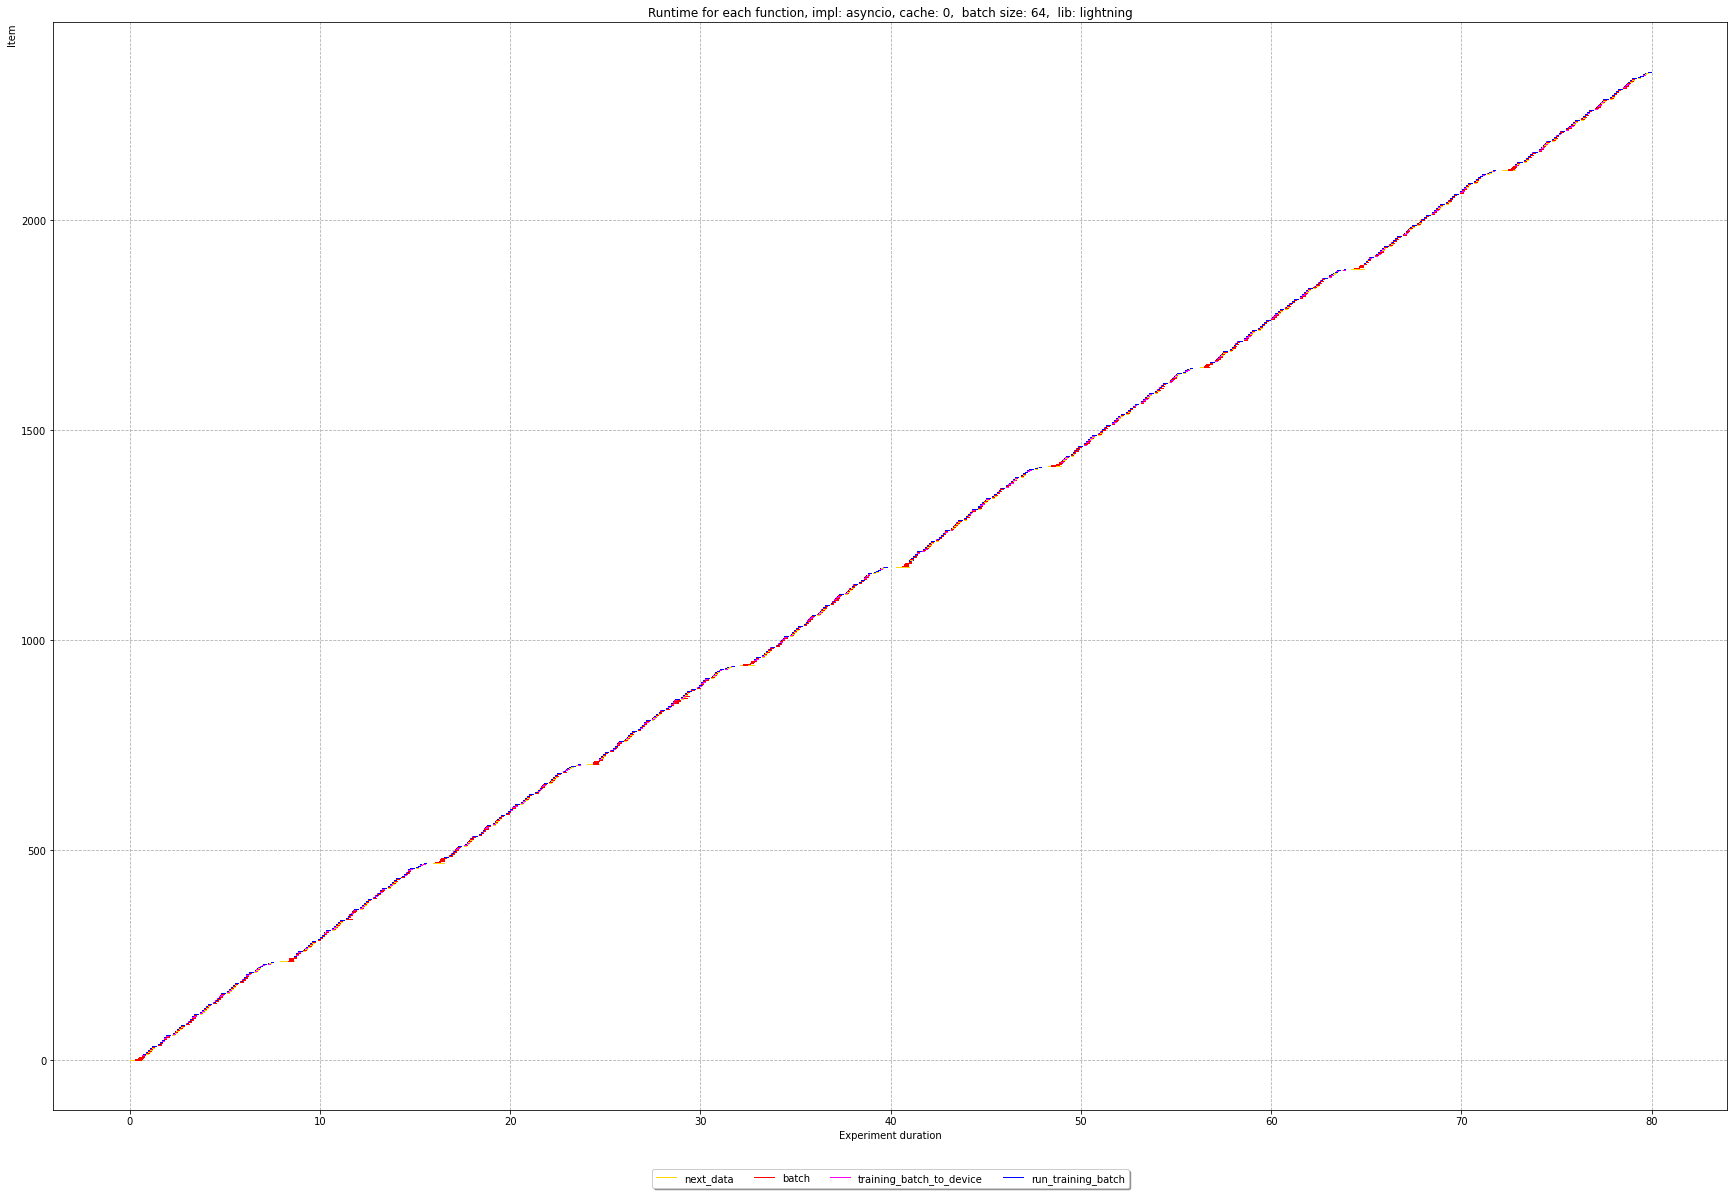

In [7]:
for implementation in ["torch", "lightning"]:
    for run in unique_runs_scratch:
        if implementation in run:
            df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
            show_timelines(df, run, lanes, colors, False, False, 1)

### GPU Utilization

In [8]:
# Load the GPU utilization 
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 13850.95it/s]


In [9]:
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])
print(unique_runs_s3, unique_runs_scratch)

['20211119f160128_benchmark_e2e_torch_s3_64_4_16_0_asyncio_sync'
 '20211119f160529_benchmark_e2e_lightning_s3_64_4_16_0_asyncio_sync'] ['20211119f160931_benchmark_e2e_torch_scratch_64_4_16_0_asyncio_sync'
 '20211119f161025_benchmark_e2e_lightning_scratch_64_4_16_0_asyncio_sync']


39.64150943396226 25.08


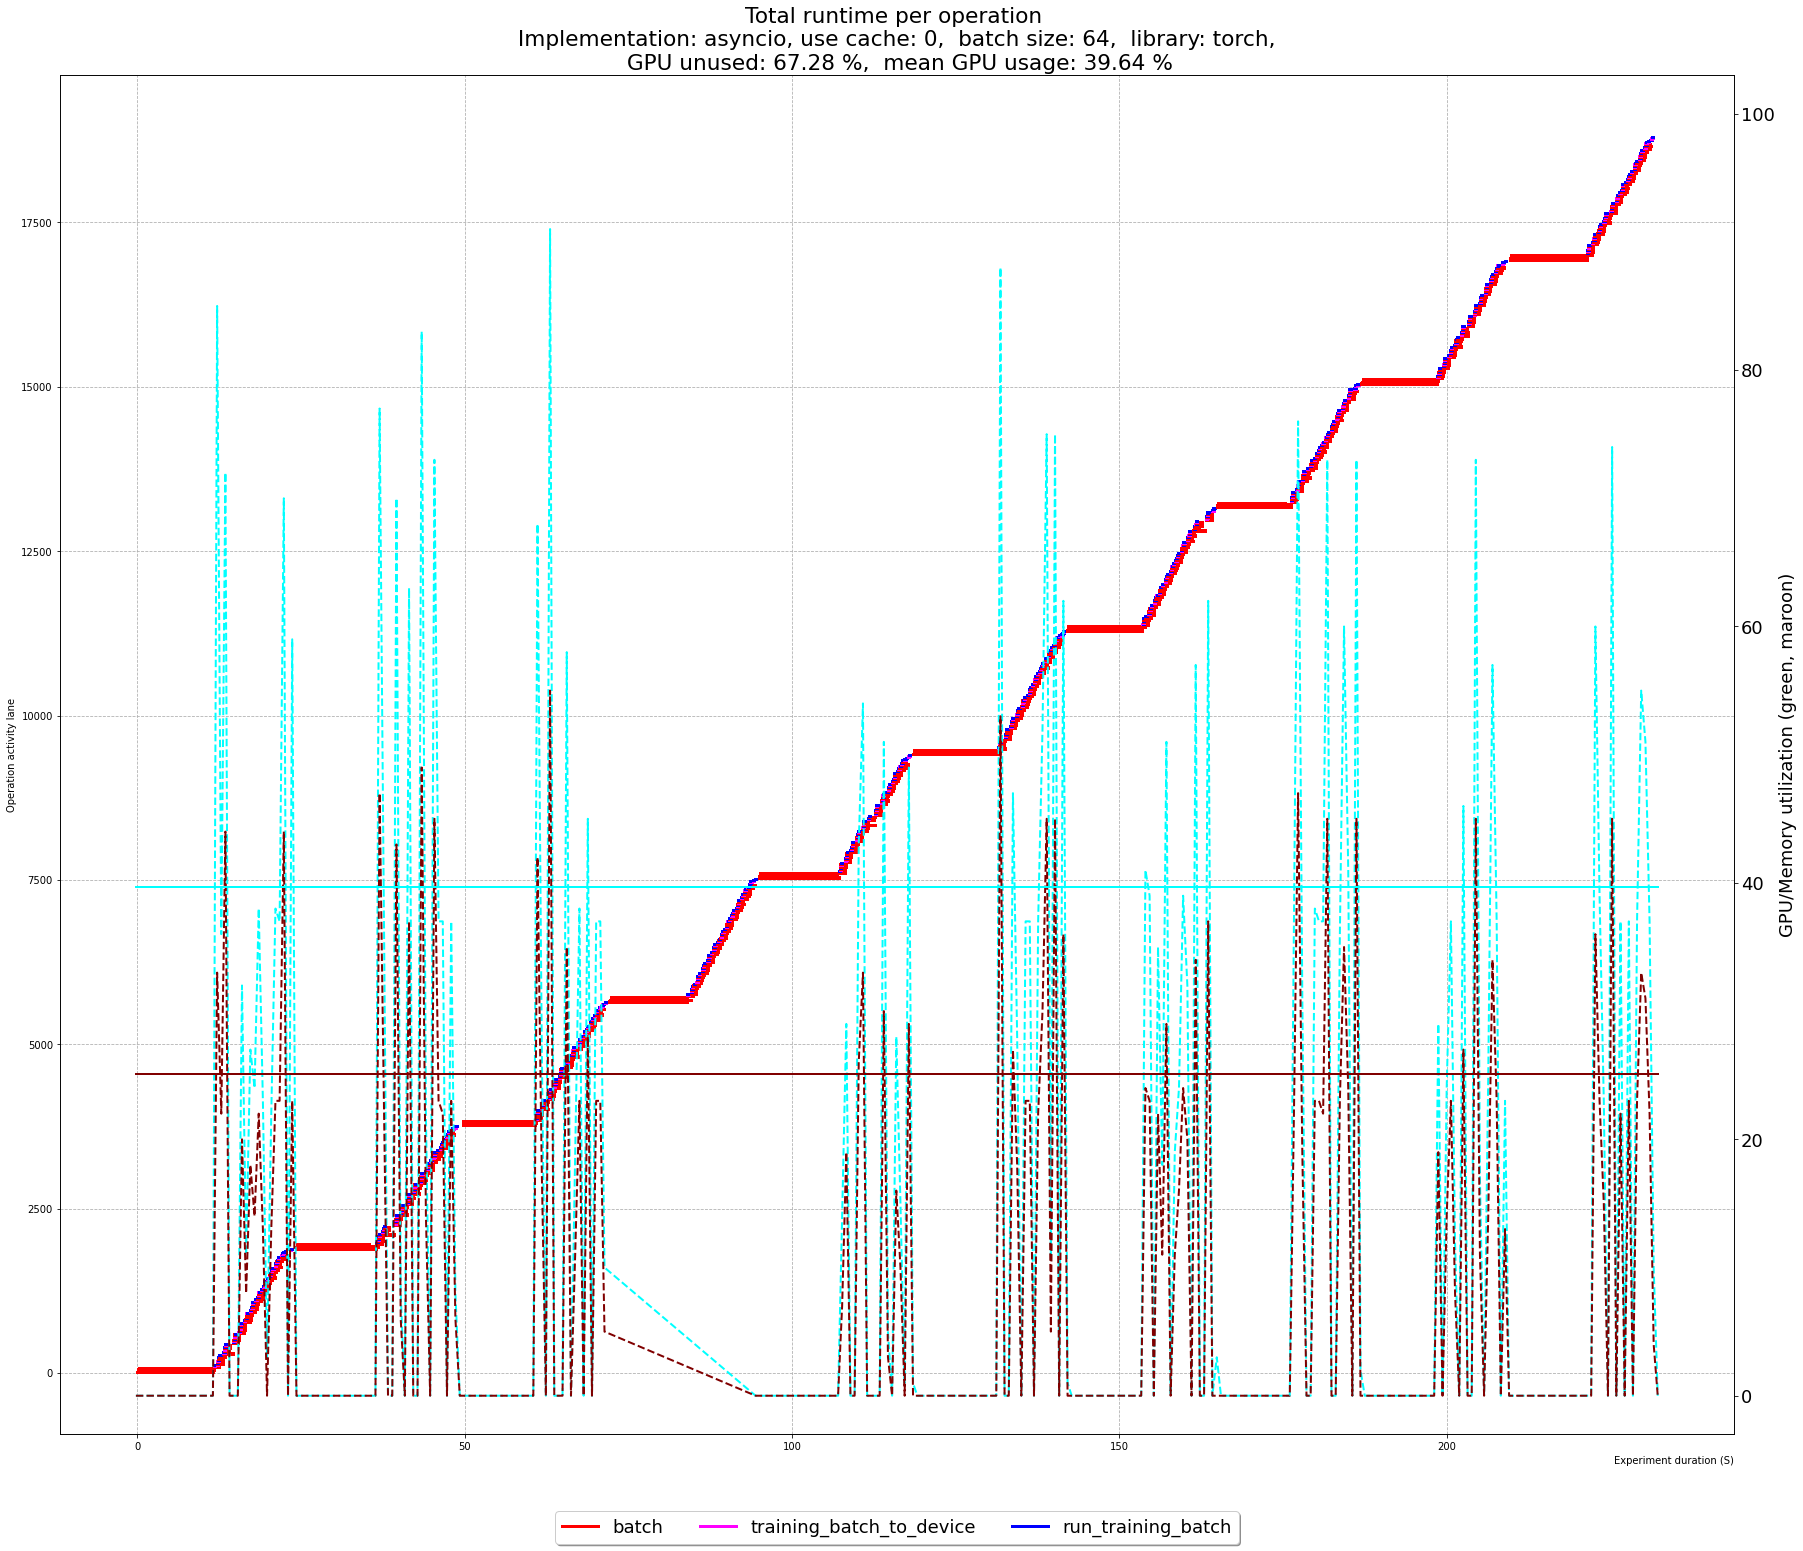

30.643356643356643 12.157894736842104


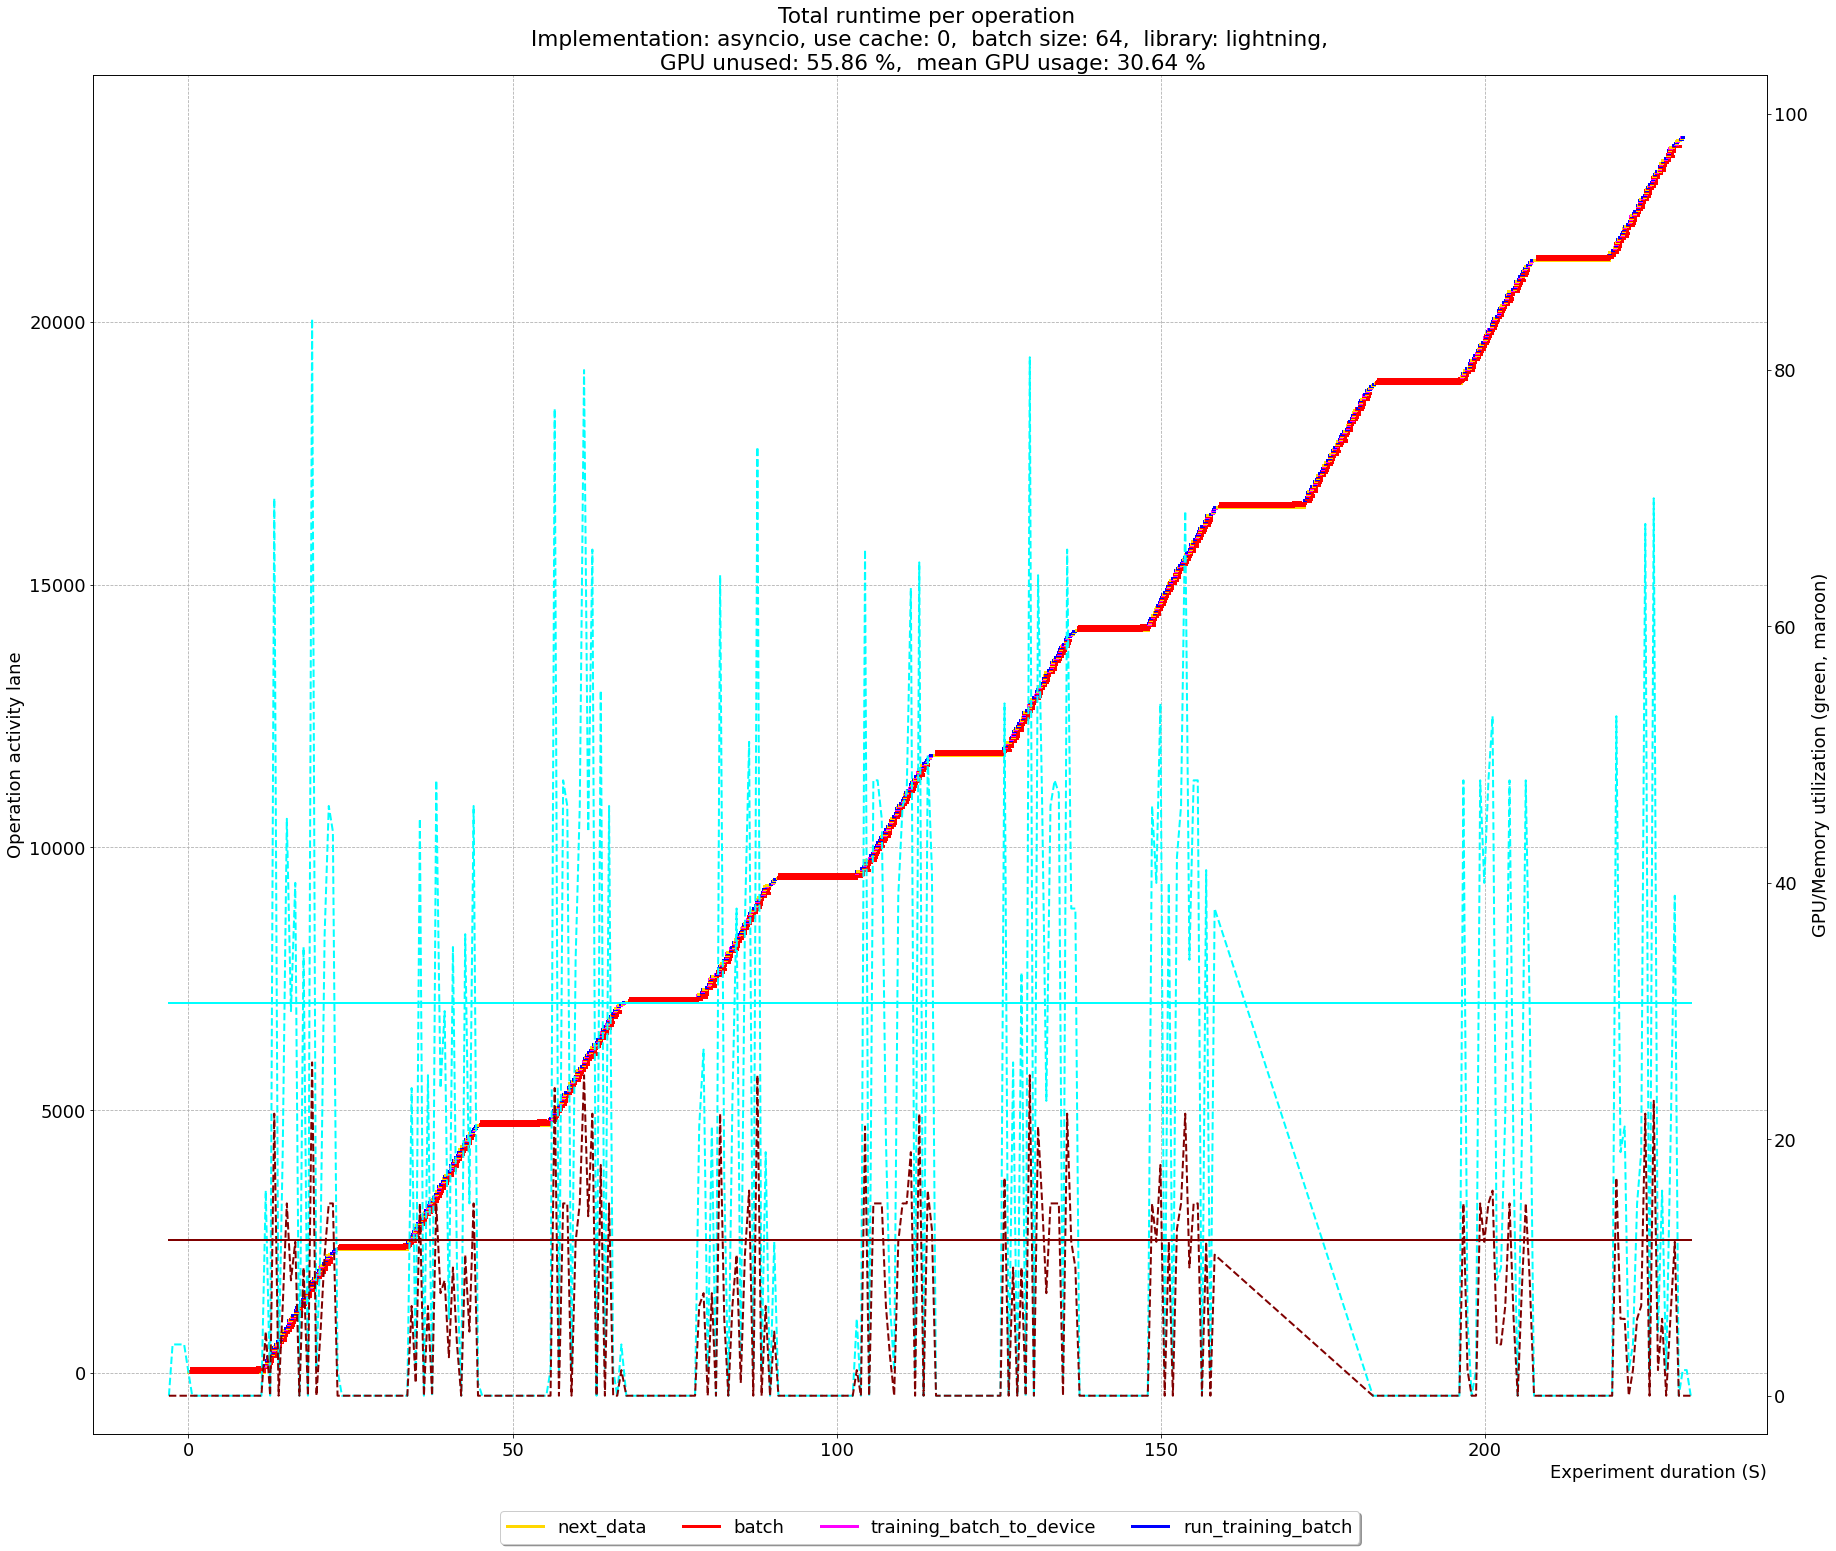

In [10]:
returns_s3 = []
for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    returns_s3.append(show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, False, 2))

62.30769230769231 39.271186440677965


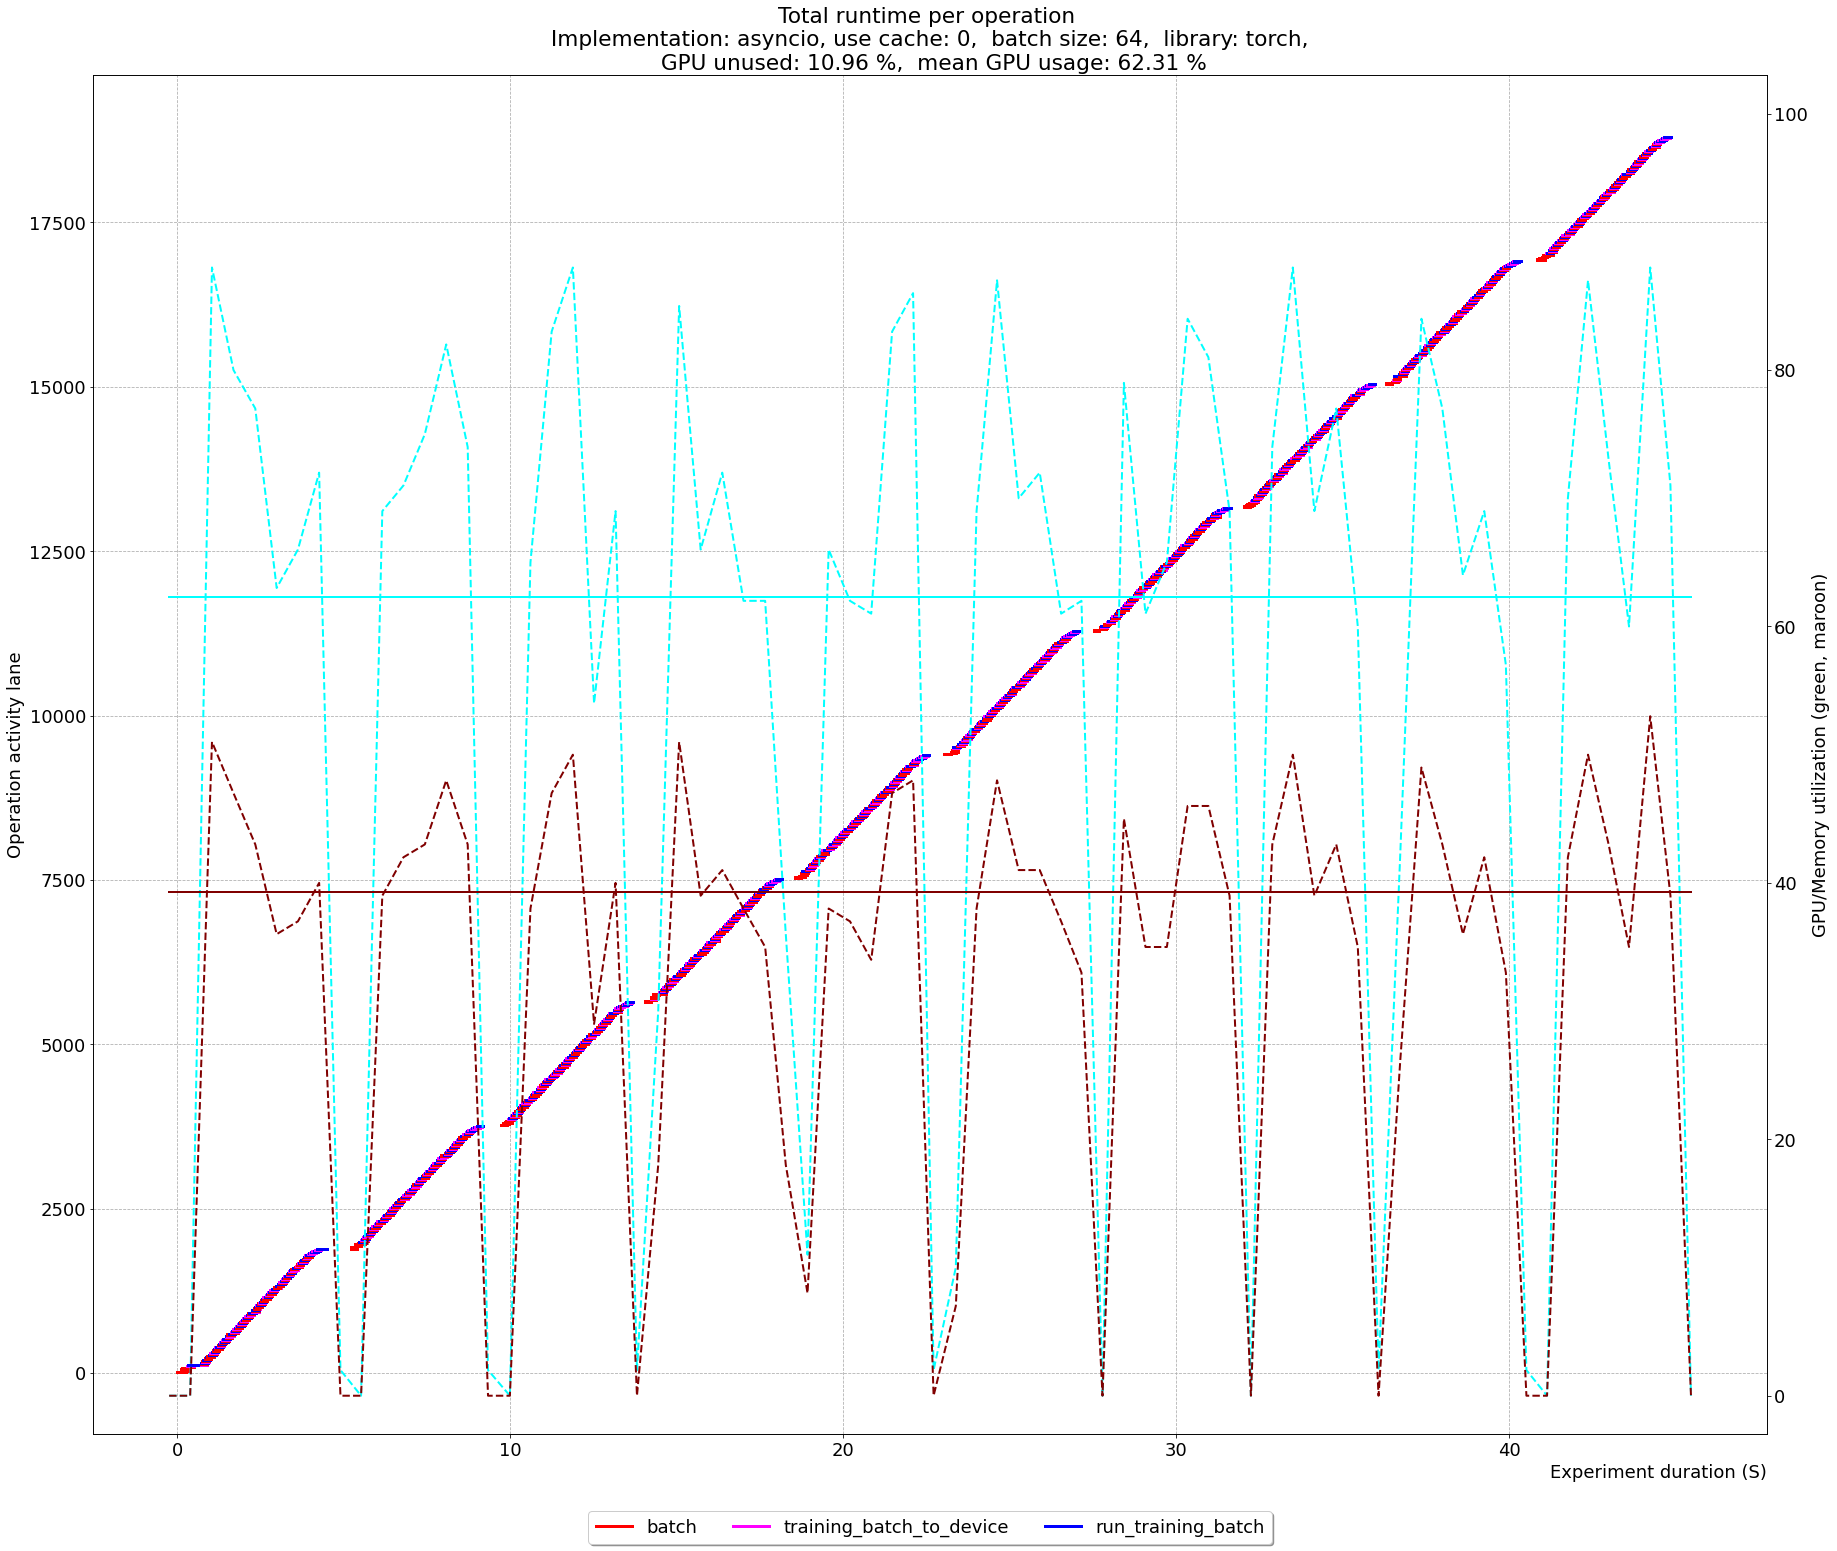

46.66942148760331 15.692982456140351


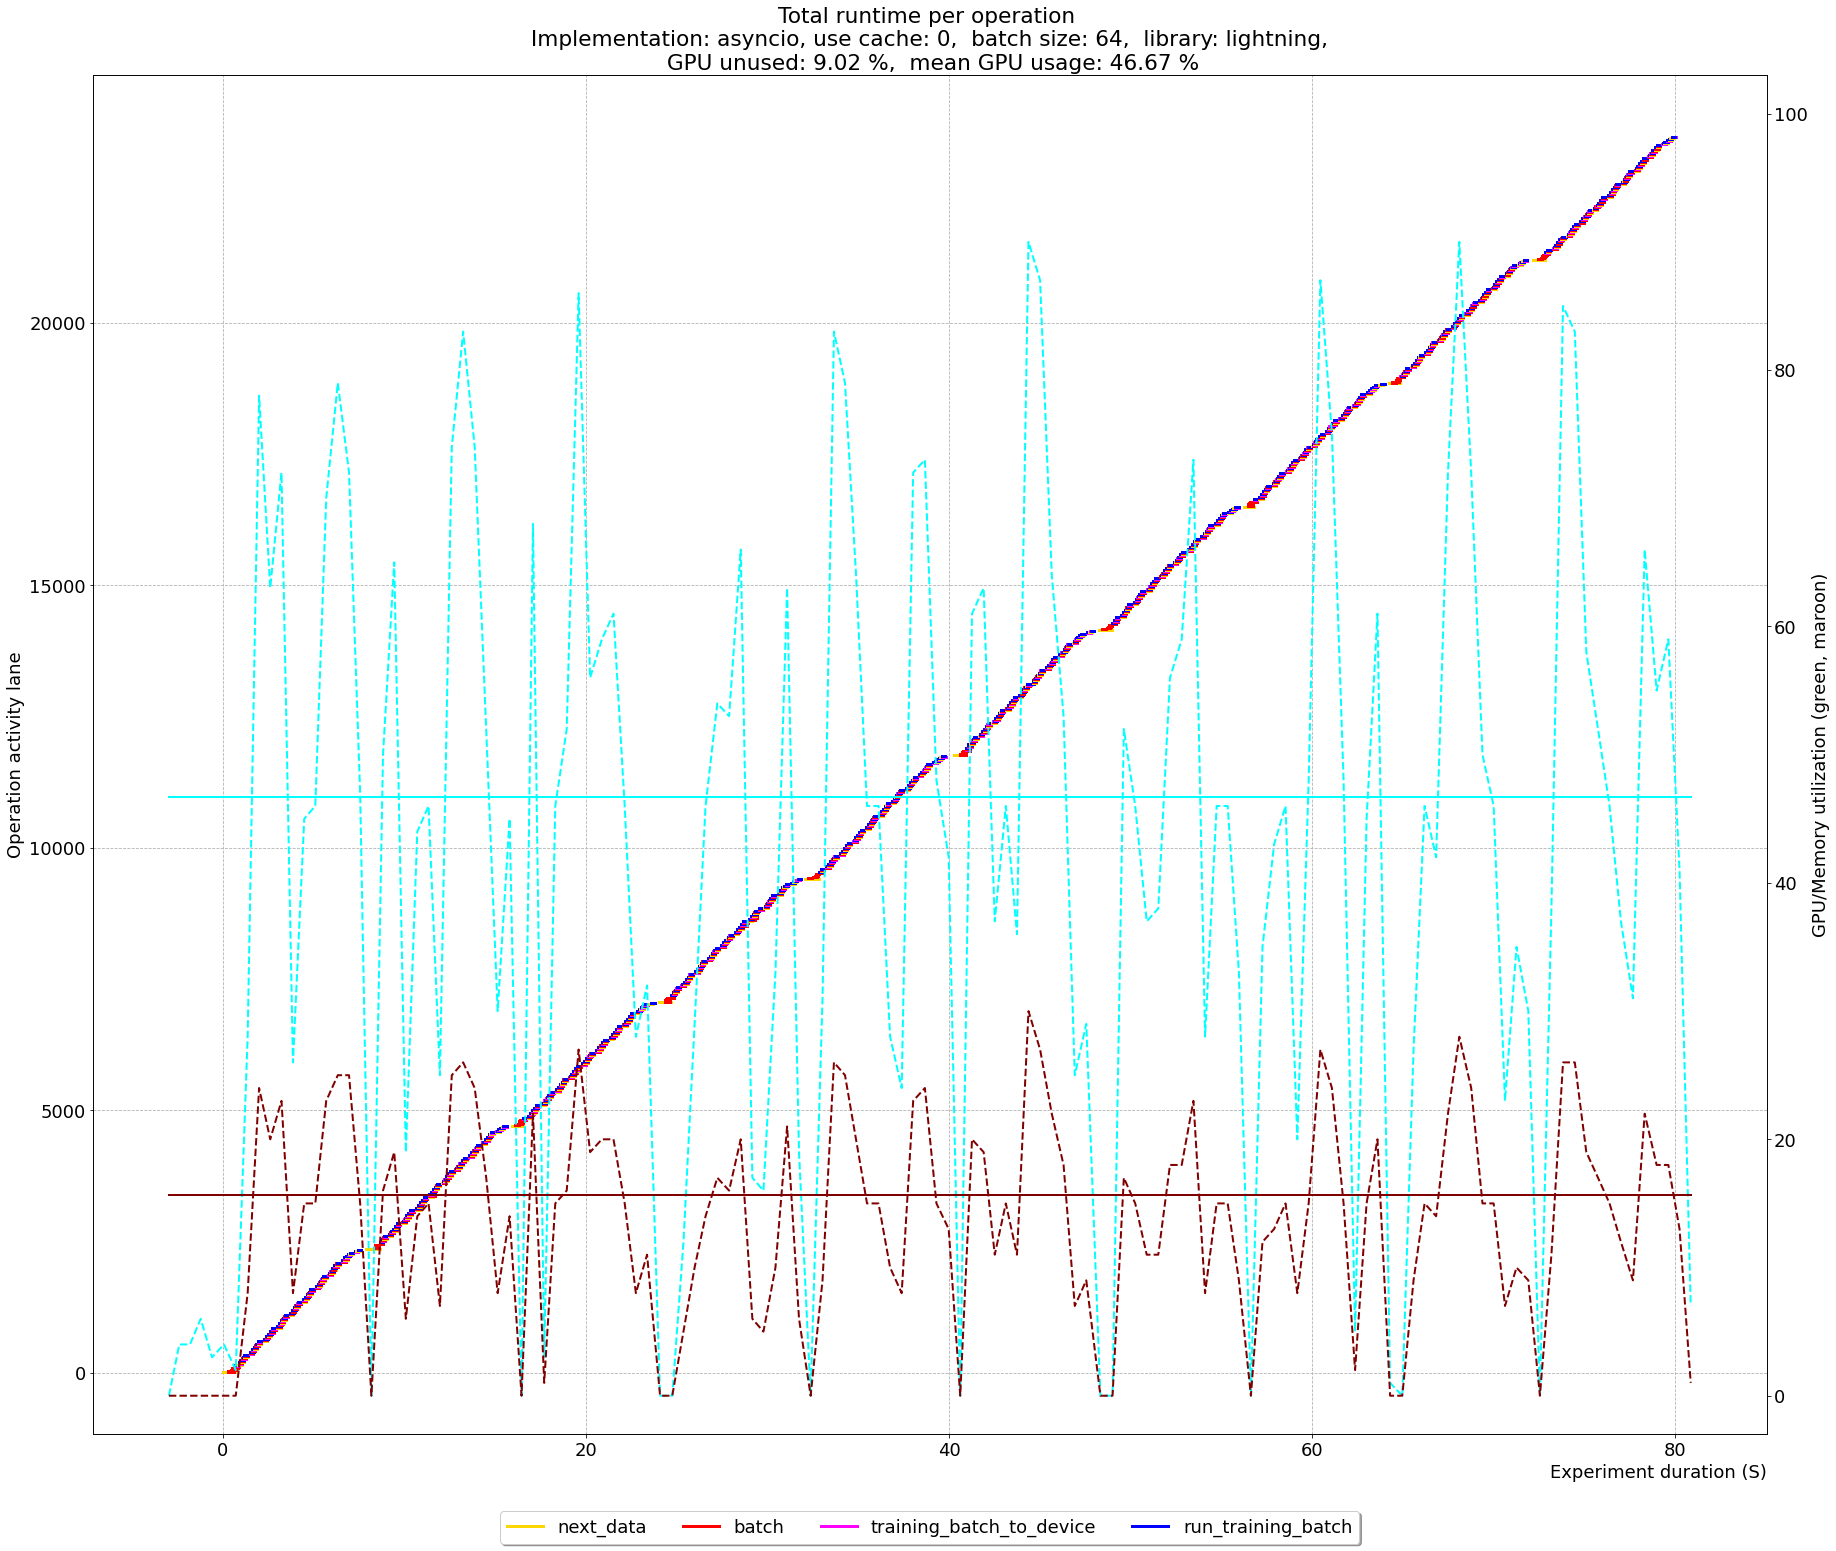

In [11]:
returns_scratch = []
for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
    returns_scratch.append(show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, False, 2))

### Result tables

The following two tables display throughput details for both experiments. The default sample size, i.e. number of dataset items is 3000.

In [12]:
samples = 3000

In [13]:
# S3
results = pd.DataFrame.from_records(data=returns_s3)
results["throughput"] = samples / results["runtime"]
results.sort_values(["runtime", "library"], ascending=True)

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput
1,230.499301,55.864198,30.643357,4.277778,12.157895,asyncio,0,lightning,13.015224
0,231.321622,67.283951,39.641509,7.740741,25.080000,asyncio,0,torch,12.968956


In [14]:
# Scratch
results = pd.DataFrame.from_records(data=returns_scratch)
results["throughput"] = samples / results["runtime"]
results.sort_values(["runtime", "library"], ascending=True)

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput
0,44.672892,10.958904,62.307692,31.739726,39.271186,asyncio,0,torch,67.154819
1,79.983938,9.022556,46.669421,13.451128,15.692982,asyncio,0,lightning,37.507531
